#  XAI roBERTa - Suicide Detection
**Autora:** Antonia Estefane Ribeiro Veras

**Orientador:** Adonias Caetano de Oliveira

**Instituição:** IFCE

**Dataset disponível em:**


## Instalação de Pacotes




In [2]:
!pip install Unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.4 MB/s eta 0:00:00


In [3]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a9aef0c0dbef468d72127a10bd78fcbf47489e94107b6a28e2e575c471299dfb
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [4]:
!pip install wordcloud

In [5]:
#hide
!pip install transformers

## Importação de Bibliotecas



In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
#text preprocessing libraries
import pandas as pd
import re
from unidecode import unidecode
from string import punctuation
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [9]:
#text classification libraries
from transformers import BertTokenizer, BertForSequenceClassification
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from lime.lime_text import LimeTextExplainer
from scipy.special import expit
from google.colab import drive


## Montagem do Drive



In [10]:
drive.mount('/content/drive')

Mounted at /content/drive


## Carregamento do Dataset


In [11]:
dataset = pd.read_csv('/content/drive/MyDrive/datasets/Suicide_Detection.csv')
# exibir as primeiras 5 linhas
dataset.head()


Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide

## Pré-Processamento de Texto

In [12]:
# Amostragem aleatória do dataset original para criar um novo dataset de treinamento menor
NEW_TRAIN_SIZE = 1000  # Tamanho desejado do novo dataset de treinamento
data_sampled = dataset.sample(n=NEW_TRAIN_SIZE, random_state=42)

In [13]:
# Carregar stopwords e mapear as classes
nltk.download('rslp')
nltk.download('stopwords')
stopwords_list = stopwords.words("english")
print(stopwords_list)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
# Defina um dicionário de mapeamento para suas classes
class_mapping = {'non-suicide': 0, 'suicide': 1}

# Mapeie as classes para os valores numéricos
data_sampled['class'] = data_sampled['class'].map(class_mapping)

# Verifique se a transformação ocorreu corretamente
data_sampled.head()

Unnamed: 0                                               text  class
74414       111734  I Don't know?7? Months self harm free and the ...      1
149516      224358  I HAVE TO START BECOMING RICH I HAVE TO START ...      0
12484        18790  A poem (haiku) for u/Me-Game-Dev hi, hello hel...      0
14043        21196  I've honestly got no idea what to do anymore.I...      1
30673        46089  Do you ever just cry? Like you just think abou...      0

In [15]:
# Pré-processamento dos textos
data_process = data_sampled.copy()

In [16]:
old_texts = data_process["text"]
new_texts = []

for text in old_texts:
    text = text.lower()
    text = re.sub('@[^\s]+', '', text)
    text = unidecode(text)
    text = re.sub('<[^<]+?>','', text)
    text = ''.join(c for c in text if not c.isdigit())
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    text = ''.join(c for c in text if c not in punctuation)
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    text = ''.join(text.replace("\"", ""))
    text = ''.join(text.replace("'", ""))
    new_texts.append(text)

data_process["text"] = new_texts

In [17]:
data_process

Unnamed: 0                                               text  class
74414       111734  dont know months self harm free urge gets stro...      1
149516      224358  start becoming rich start company become affor...      0
12484        18790  poem haiku umegamedev hi hello hello stop fuck...      0
14043        21196  ive honestly got idea anymoreit feels everyone...      1
30673        46089  ever cry like think unfair life cry cant cry e...      0
...            ...                                                ...    ...
89778       134858  crying againi feel unbelievably terrible thoug...      1
6705         10045  yearsits almost years since hung head cloud li...      1
112057      168382  wtf wrong people figured someone murdered grea...      0
111018      166876  fact day north island new zealand place named ...      0
42289        63399  schools kids mental health happening school su...      0

[1000 rows x 3 columns]

## Visualização dos Dados

<Axes: xlabel='class', ylabel='count'>

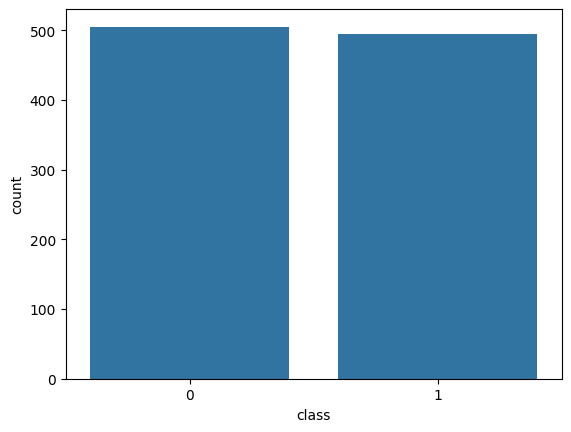

In [18]:
sns.countplot(x = data_process['class'])

## Balanceamento dos Dados


<Axes: xlabel='class', ylabel='count'>

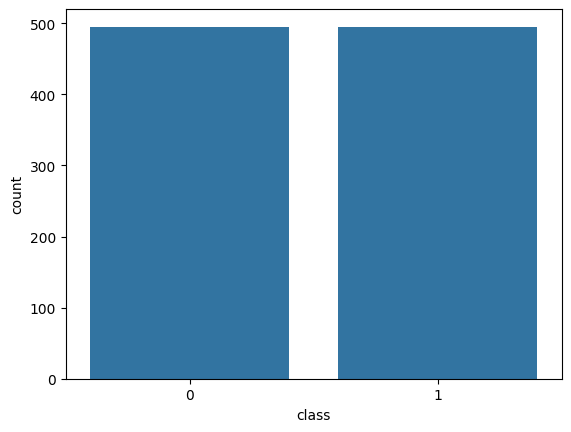

In [19]:
rus = RandomUnderSampler(random_state= 0)
X_bal, Y_bal = rus.fit_resample(data_process[['text']], data_process['class'])
sns.countplot(x = Y_bal)

##Criação da Wordcloud


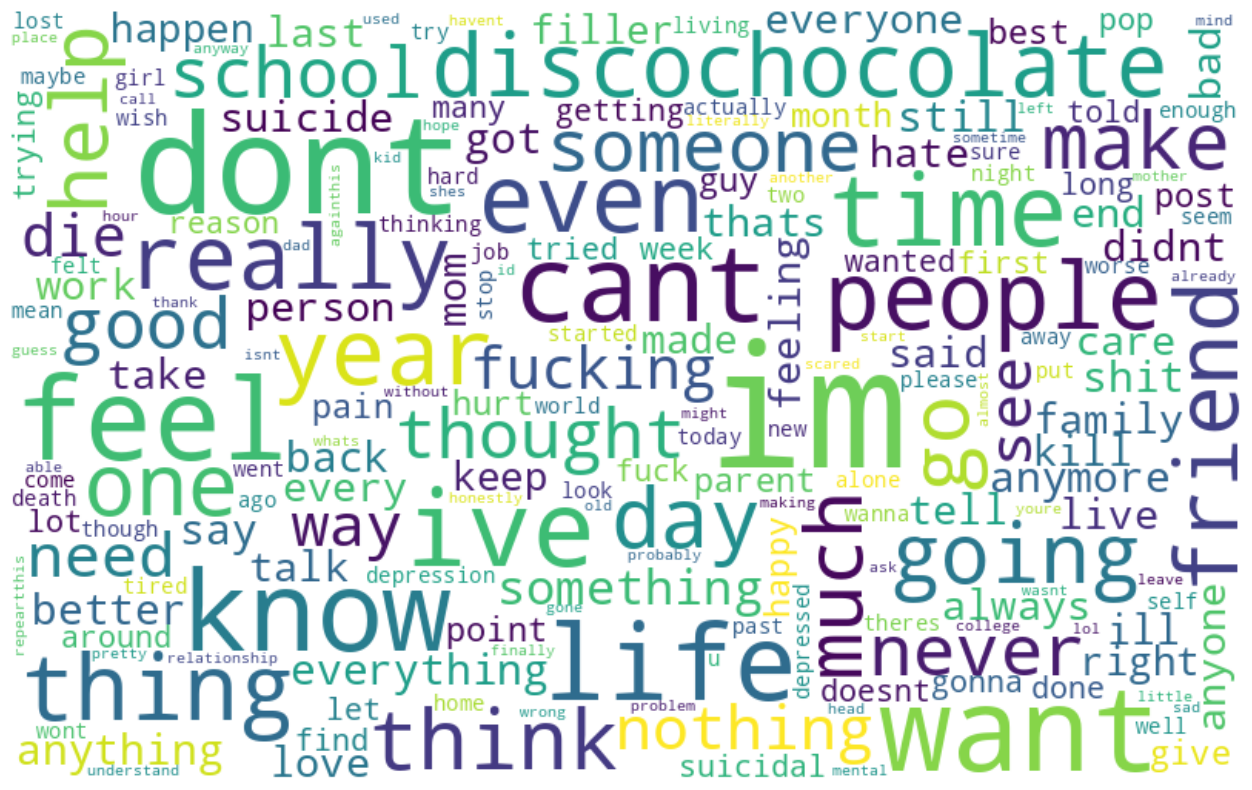

In [20]:
new_texts = data_process["text"]
all_words = ' '.join([text for text in new_texts])
word_cloud = WordCloud(width= 800, height= 500, max_font_size = 110, background_color="white", collocations = False).generate(all_words)
plt.figure(figsize=(20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Divisão dos Dados em Conjuntos de Treinamento, Validação e Teste


In [21]:
train_df, test_df, train_label, test_label = train_test_split(X_bal, Y_bal, test_size=0.20, random_state=42)

In [22]:
train_df, valid_df, train_label,  valid_label = train_test_split(train_df, train_label, test_size=0.20, random_state=42)

##Inicialização do Tokenizador e do Modelo


In [23]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

PRETRAINED_LM = 'roberta-base'
# tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer = RobertaTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

# PRETRAINED_LM = 'roberta-base'  # Você pode usar outros modelos pré-treinados além do 'roberta-base' se desejar
# tokenizer = RobertaTokenizer.from_pretrained(PRETRAINED_LM)
# model = RobertaForSequenceClassification.from_pretrained(PRETRAINED_LM, num_labels=N_labels)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

RobertaTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

##Definição de Funções Auxiliares


In [24]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

## preparação dos dados para o treinamento do modelo

In [25]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

In [26]:
import torch
train_y = torch.LongTensor(train_label.values)
valid_y = torch.LongTensor(valid_label.values)
test_y = torch.LongTensor(test_label.values)
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([633]), torch.Size([159]), torch.Size([198]))

##configuração dos dataloaders para treinamento, validação e teste

In [27]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [28]:
train_label.unique()

array([0, 1])

In [29]:
# Configuração do modelo RoBERTa
N_labels = len(train_label.unique())
model = RobertaForSequenceClassification.from_pretrained(PRETRAINED_LM, num_labels=N_labels)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
model = model.to(device)


In [71]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Best results: 07 and 08
EPOCHS = 23
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

## Treinamento do modelo

In [72]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.012393634981617652 
10/10 val loss: 0.936885385224923 
Epoch:  2


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 3.593944607018784e-05 
10/10 val loss: 1.1412769935268443 
Epoch:  3


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.017071068607037887 
10/10 val loss: 0.949058914588386 
Epoch:  4


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.005262364464078928 
10/10 val loss: 0.9663415900214204 
Epoch:  5


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.01713083173258383 
10/10 val loss: 0.9948293736345477 
Epoch:  6


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.014529141340290153 
10/10 val loss: 0.9983944144649286 
Epoch:  7


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.0008575799162372277 
10/10 val loss: 1.1424932665308005 
Epoch:  8


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.00620841393720184 
10/10 val loss: 0.9474317390615397 
Epoch:  9


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.0014274319515607202 
10/10 val loss: 0.9706736095142332 
Epoch:  10


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 3.743982786090783e-05 
10/10 val loss: 0.9880860422431397 
Epoch:  11


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.0005649899482477849 
10/10 val loss: 0.9561467415647712 
Epoch:  12


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 1.7151382871816166e-05 
10/10 val loss: 0.9819249807499546 
Epoch:  13


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 1.5106229284356232e-05 
10/10 val loss: 0.9892357714448735 
Epoch:  14


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.018469610881834343 
10/10 val loss: 1.1066774733921192 
Epoch:  15


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 1.4403088516701246e-05 
10/10 val loss: 0.9710386476960593 
Epoch:  16


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 1.464472009047313e-05 
10/10 val loss: 0.976206157224442 
Epoch:  17


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 0.00016056551758083514 
10/10 val loss: 0.9741402690709038 
Epoch:  18


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 1.3296203405843698e-05 
10/10 val loss: 0.9761071735729274 
Epoch:  19


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 1.3100861247039575e-05 
10/10 val loss: 0.9777591547697739 
Epoch:  20


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 1.3127890701980504e-05 
10/10 val loss: 0.9788187199093954 
Epoch:  21


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 1.2483876844271435e-05 
10/10 val loss: 0.979601464382813 
Epoch:  22


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 1.3122751306582359e-05 
10/10 val loss: 0.9806704258473473 
Epoch:  23


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

40/40 train loss: 1.27031226611507e-05 
10/10 val loss: 0.9808769987124834 


## Avaliação do Modelo


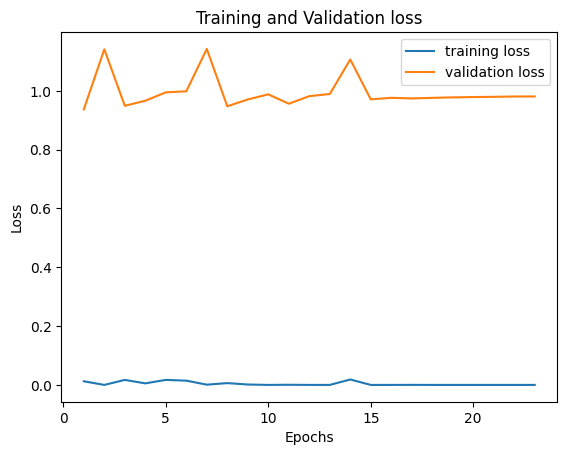

In [73]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [74]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, valid_label.to_numpy()))


classifiation report
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        75
           1       0.94      0.89      0.91        84

    accuracy                           0.91       159
   macro avg       0.91      0.91      0.91       159
weighted avg       0.91      0.91      0.91       159



In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

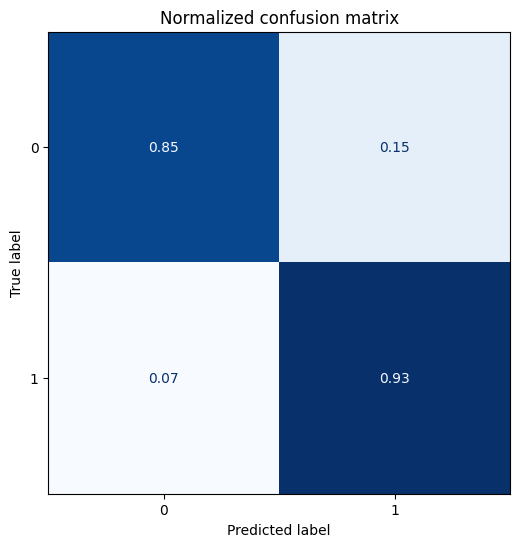

In [37]:
plot_confusion_matrix(valid_pred,valid_label.to_numpy())

In [38]:
def createDataloader(text):
  test_input_ids, test_att_masks = encode([text])
  BATCH_SIZE = 16
  test_y = torch.LongTensor([0])
  test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)
  return test_dataloader

In [39]:
def predict(text, labels_names):
    model.eval()
    test_dataloader = createDataloader(text)

    with torch.no_grad():
        for step_num, batch_data in tqdm(enumerate(test_dataloader)):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)

            logits = output.logits.cpu().detach().numpy()
            index_pred = np.argmax(logits, axis=-1)[0]
            probabilities = expit(logits)[0]

    df = pd.DataFrame(columns=['Label', 'Probabilidade'])
    df['Label'] = labels_names
    df['Probabilidade'] = probabilities

    return index_pred, labels_names[index_pred], df

In [40]:
labels_names = ['non-suicide', 'suicide']
text = 'think better night posts pretty shit shitposts rn like 7 ish hours making shitty posts sorry'
index_pred, label, df = predict(text, labels_names)

0it [00:00, ?it/s]

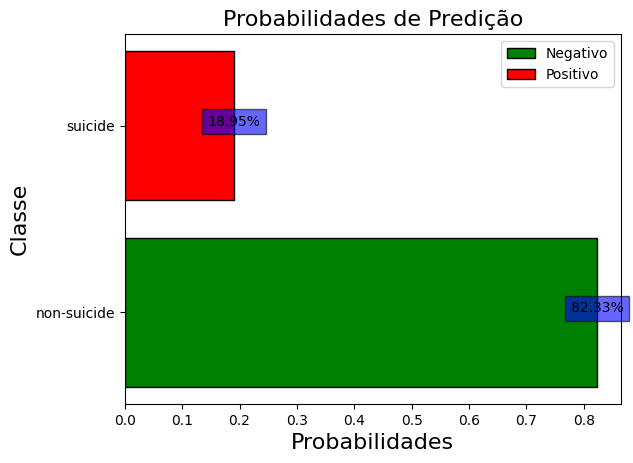

In [41]:
import matplotlib.pyplot as plt
import numpy as np

def addlabels(x, y):
    for i in range(len(x)):
        plt.text(y[i], i, str(f'{y[i]*100:0.2f}%'), ha='center', bbox=dict(facecolor='blue', alpha=.6))

plt.clf()

pos = np.arange(len(df['Label'].values))
probabilidades = df['Probabilidade'].values

# Definir as cores para cada classe
colors = df['Label'].map({'non-suicide': 'g', 'suicide': 'r'})

# Criar o gráfico de barras
fig = plt.barh(pos, probabilidades, color=colors, edgecolor='black')
plt.yticks(pos, df['Label'])  # Exibir cada classe no eixo y
plt.legend(fig, [str(i) for i in ['Negativo', 'Positivo']])  # Exibir a legenda de cada classe (Positivo ou Negativo)
plt.xlabel('Probabilidades', fontsize=16)
plt.ylabel('Classe', fontsize=16)
addlabels(pos, probabilidades)  # Chamar a função para adicionar rótulos de valores
plt.title('Probabilidades de Predição', fontsize=16)
plt.show()


## Interpretabilidade do Modelo com Lime


In [42]:
def predict_proba(sentences):
  model.eval()
  probabilities = []

  test_input_ids, test_att_masks = encode(sentences)
  BATCH_SIZE = 16
  test_y = torch.LongTensor([0] * len(sentences))
  test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
  test_sampler = SequentialSampler(test_dataset)
  test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

  with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        probabilities.append(expit(output.logits.cpu().detach().numpy()))

  probabilities = np.concatenate(probabilities)

  return probabilities

In [43]:
# labels_names = ['non-suicide', 'suicide']

In [44]:
explainer = LimeTextExplainer(class_names = labels_names)

In [45]:
exp = explainer.explain_instance('know 7 months self harm free urge gets stronger stronger every day past days shit family stresses especially nephew 12 mum full custody told go kill numerous times wish easy partners family stresses especially past days stress trigger want scream cry live near woods could go scream till ca possibly scream anymore cops probably get called oh knows depression really know feeling moment would want come make sure ok fucking annoying annoys time small stupid things even know going post', classifier_fn = predict_proba, num_features = 10)

0it [00:00, ?it/s]

In [46]:
exp.show_in_notebook(text = True)

In [47]:
from IPython.core.display import display, HTML
display(HTML(exp.as_html()))

In [48]:
exp = explainer.explain_instance('feeling depressed stressed someone actually caring talk feel like dearth caring affectionate people planet everyone terrible indifferent write paragraphs paragraphs text make someone feel important never get return', classifier_fn = predict_proba, num_features = 10)

0it [00:00, ?it/s]

In [49]:
exp.show_in_notebook(text = True)

In [50]:
from IPython.core.display import display, HTML
display(HTML(exp.as_html()))

In [51]:
def execute_classify(input):

  if model != None:
    test_pred = predict(input)
    label = labels_names[test_pred[0]]
    return f"A classe prevista foi: {label}"
  else:
    return "Não há texto ou modelo para classificação!"

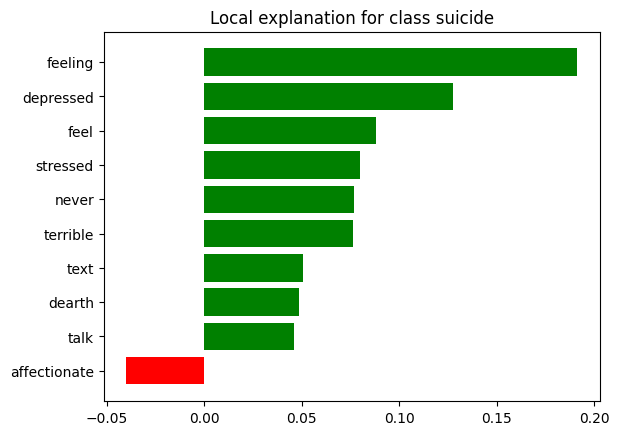

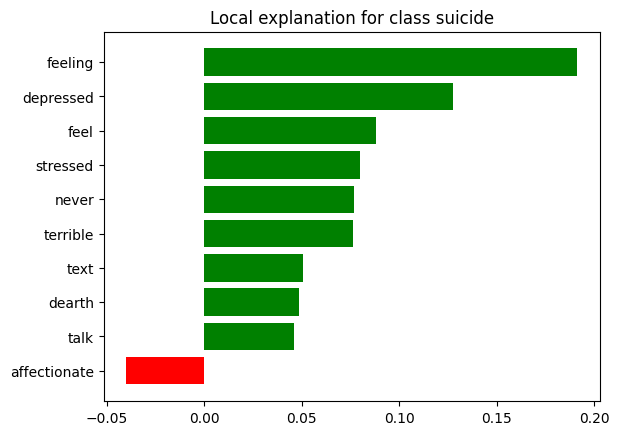

In [52]:
exp.as_pyplot_figure()